<a href="https://colab.research.google.com/github/Zhdanko-Gleb/Path-planning/blob/main/RRT_RRTstar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import yaml
from pprint import pprint
import matplotlib.pyplot as plt
import random
import math
from matplotlib.pyplot import figure
from collections import defaultdict
from shapely.geometry import Point, Polygon,LineString
import time


#random.seed(11)

def read(name):
    with open(name) as f:
        templates = yaml.safe_load(f)
        bordersize = templates['bordersize']
        start = templates['start']
        finish = templates['finish']
        num_obs = templates['num_obstacles']
        obstacles = templates['obstacles']
    return bordersize,start,finish,num_obs,obstacles

def distance(a,b,x,y):
    return math.sqrt((a-x)**2 + (b-y)**2)


def find_nearest_vertex_rrt(g,x,y):
    min_dist = 10000000
    v_x = 0
    v_y = 0
    for vert in g:
        a = distance(vert[0],vert[1],x,y)
        if a<min_dist:
            min_dist = a
            v_x = vert[0]
            v_y = vert[1]
    return v_x,v_y

def find_nearest_vertex_rrt_star(g,x,y,neighbourhood_dist):
    neighbourhood = []
    for vert in g:
        a = distance(vert[0],vert[1],x,y)
        if a<neighbourhood_dist:
            neighbourhood.append([vert,a])
    return neighbourhood

def move(a,b,x,y,dist):
    v1 = a-x
    v2 = b-y
    norm_v = math.sqrt(v1*v1+v2*v2)
    return [round(x+ (v1/norm_v)*dist,2), round(y+(v2/norm_v)*dist,2)]

def check_points(x, y,obstacles):
    p = Point((x,y))
    for obs in obstacles: 
        a = obs['points'][0]
        b = obs['points'][1]
        z = [(a[i],b[i]) for i in range(1,len(a))]
        poly = Polygon(z)
        if (poly.contains(p)) or (poly.touches(p)):
            return True
    return False

def check_borders(bordersize,vert):
    x = vert[0]
    y = vert[1]
    if x<=bordersize[0] or x>=bordersize[1]:
        return True
    if y<=bordersize[2] or y>=bordersize[3]:
        return True
    return False

def check_final(a,b,radius):
    return (a[0]-b[0])**2 + (a[1]-b[1])**2 < radius**2

def build_path(graph,parent,final,start):
    path = []
    q = final
    while not(q[0]== start[0] and q[1]==start[1]):
        path.append(q)
        q = parent[(q[0],q[1])]
    path.append(start)
    return path

def calculate_len(path):
    length = 0

    for i in range(len(path)-1):
        length +=distance(path[i][0],path[i][1],path[i+1][0],path[i+1][1])
    return length

def edge_intersec(p1,p2,obstacles):
    edge = LineString([p1,p2])
    for obs in obstacles:
        x = obs['points'][0]
        y = obs['points'][1]
        for i in range(1,len(x)):
            a = Point((x[i-1]),(y[i-1]))
            b = Point((x[i]),(y[i]))
            line = LineString([a,b])
            if (edge.intersects(line)) or (edge.touches(line)):
                return True
    else: 
        return False

def rrt(bordersize,start,finish,num_obs,obstacles,dist,steps,radius):
    # dist - длина каждого шага
    path = []
    graph = []
    graph.append(start)
    parent = {}
    final_point = 0
    mindist = radius
    number_of_vertices = 0
    while number_of_vertices<steps: 
        x = round(random.uniform(bordersize[0],bordersize[1]),3)
        y = round(random.uniform(bordersize[2],bordersize[3]),3)
        near_point_x,near_point_y = find_nearest_vertex_rrt(graph,x,y)
        new_vert = move(x,y,near_point_x,near_point_y,dist)
        number_of_vertices+=1
        if check_borders(bordersize,new_vert):
            continue
        if check_points(new_vert[0],new_vert[1],obstacles):
            continue
        #Проверка пересекает ли новое ребро граф
        if edge_intersec(new_vert,(near_point_x,near_point_y),obstacles):
            continue
        graph.append(new_vert)
        if (check_final(finish,new_vert,radius)) and (distance(finish[0],finish[1],new_vert[0],new_vert[1])<mindist):
            final_point = new_vert
            mindist = distance(finish[0],finish[1],new_vert[0],new_vert[1])
        parent[(new_vert[0],new_vert[1])] = (near_point_x,near_point_y)

        if final_point!=0: 
            break
    if final_point!=0:
        path = build_path(graph,parent,final_point,start)
    return graph,parent,path,number_of_vertices

def rrt_star(bordersize,start,finish,num_obs,obstacles,dist,steps,radius):
    # dist - длина каждого шага
    path = []
    graph = []
    graph.append(start)
    parent = {}
    final_point = 0
    mindist = radius
    neighbourhood_dist = dist
    cost = {}
    cost[(start[0],start[1])] = 0
    
    number_of_vertices = 0
    while number_of_vertices<steps: 
        x = round(random.uniform(bordersize[0],bordersize[1]),3)
        y = round(random.uniform(bordersize[2],bordersize[3]),3)
        near_point_x,near_point_y = find_nearest_vertex_rrt(graph,x,y)
        new_vert = move(x,y,near_point_x,near_point_y,dist)
        number_of_vertices+=1
        if check_borders(bordersize,new_vert):
            continue
        if check_points(new_vert[0],new_vert[1],obstacles):
            continue
        #Ишем самого близкого соседа с минимальной стоимостью пути от начальной вершины
        neighbourhood = find_nearest_vertex_rrt_star(graph,new_vert[0],new_vert[1],neighbourhood_dist)
        min_cost = dist*100
        nearest_vertex = [near_point_x,near_point_y]
        for vert,n_dist in neighbourhood:
            #Проверка пересекает ли новое ребро граф
            if edge_intersec(new_vert,vert,obstacles):
                continue
            if cost[(vert[0],vert[1])]+n_dist<min_cost:
                nearest_vertex = vert
                min_cost = cost[(vert[0],vert[1])]+n_dist
        if min_cost==dist*100:
            continue
        cost[(new_vert[0],new_vert[1])] = min_cost
        parent[(new_vert[0],new_vert[1])] = (nearest_vertex)
        graph.append(new_vert)
        #rewiring
        for vert,n_dist in neighbourhood:
            if  not(edge_intersec(new_vert,vert,obstacles))and (cost[(vert[0],vert[1])]>n_dist+min_cost):
                parent[(vert[0],vert[1])] = (new_vert[0],new_vert[1])
                cost[(vert[0],vert[1])]=n_dist+min_cost
        
        if (check_final(finish,new_vert,radius)) and (distance(finish[0],finish[1],new_vert[0],new_vert[1])<mindist):
            final_point = new_vert
            mindist = distance(finish[0],finish[1],new_vert[0],new_vert[1])

    if final_point!=0:
        path = build_path(graph,parent,final_point,start)
    return graph,parent,path,number_of_vertices

def main(input_name,steer,tolerance,epochs,algorithm='rrtstar'):
    [bordersize,start,finish,num_obs,obstacles] = read(input_name)
    if algorithm == 'rrt':
        graph,parent,path,number_of_vertices = rrt(bordersize,start,finish,num_obs,obstacles,steer,epochs,tolerance)
    else:
        graph,parent,path,number_of_vertices = rrt_star(bordersize,start,finish,num_obs,obstacles,steer,epochs,tolerance)
    data = {'graph':graph,'path':path}
    for_picture = [bordersize,start,finish,obstacles,num_obs,graph,parent,path]
    if path:
       print('Found path, length: '+ str(calculate_len(path)))
       print('Number of vertices: '+ str(number_of_vertices))
       
    else:
        print('NO PATH')
    return for_picture

In [22]:
start_time = time.time()
w = main(input_name = 'input2.yaml',steer = 0.7,tolerance = 1, epochs = 1000, algorithm = 'rrtstar')
print("--- %s seconds ---" % (time.time() - start_time))

Found path, length: 7.970813764111452
Number of vertices: 1000
--- 2.991767644882202 seconds ---


## Можно изобразить граф

In [13]:
def draw_graph(graph,parent):
    for i in graph:
        if (i[0],i[1]) in parent:
            plt.plot([parent[(i[0],i[1])][0],i[0],],[parent[(i[0],i[1])][1],i[1]],'-o',markersize = '2',linewidth=1,color='blue')


def draw_obstacles(obstacles,n):
    for i in range(n):
        obs = obstacles[i]['points']
        x = obs[0]
        y = obs[1]
        plt.plot(x, y,'r')

def draw_path(path):
    x = [i[0] for i in path]
    y = [i[1] for i in path]
    plt.plot(x,y,'black')

def picture(for_picture):
    bordersize,start,finish,obstacles,num_obs,graph,parent,path = for_picture
    plt.figure(figsize=(6,6),dpi=100)
    draw_obstacles(obstacles,num_obs)
    draw_graph(graph,parent)
    plt.plot(start[0],start[1], marker="*",markersize = '7', markerfacecolor="green")
    plt.plot(finish[0],finish[1], marker="*",markersize = '7', markerfacecolor="red")
    plt.axis(bordersize)
    plt.xticks(range(bordersize[0],bordersize[1]))
    plt.yticks(range(bordersize[2],bordersize[3]))
    plt.grid()
    plt.show()

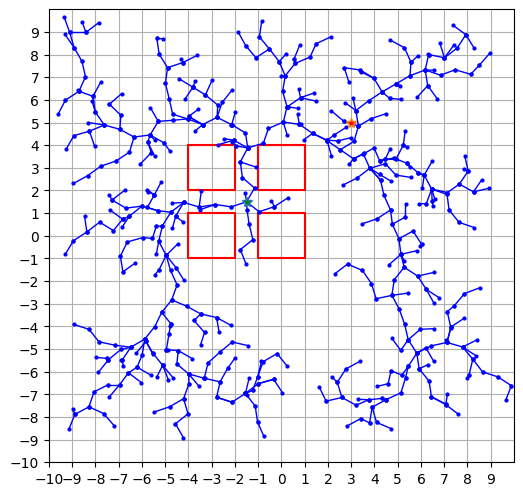

In [23]:
picture(w)